In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
bs=128

In [2]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [13]:
import torch.nn as nn
import torch.nn.functional as F

In [4]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2
# convert data to torch.FloatTensor
transform = transforms.ToTensor()
# choose the training and testing datasets
train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                           sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                          sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                         num_workers = num_workers)

Using downloaded and verified file: data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw
Using downloaded and verified file: data/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw
Using downloaded and verified file: data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...


/home/jingjinglab/cw/miniconda3/envs/Harry_env/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


<ipython-input-5-e5d5236ded26>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


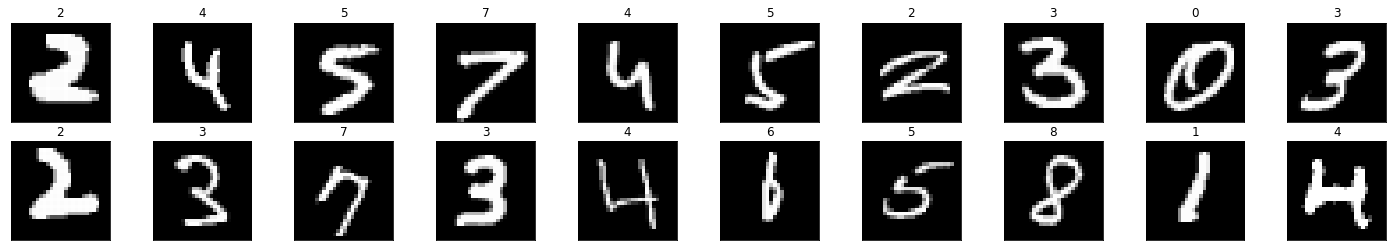

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

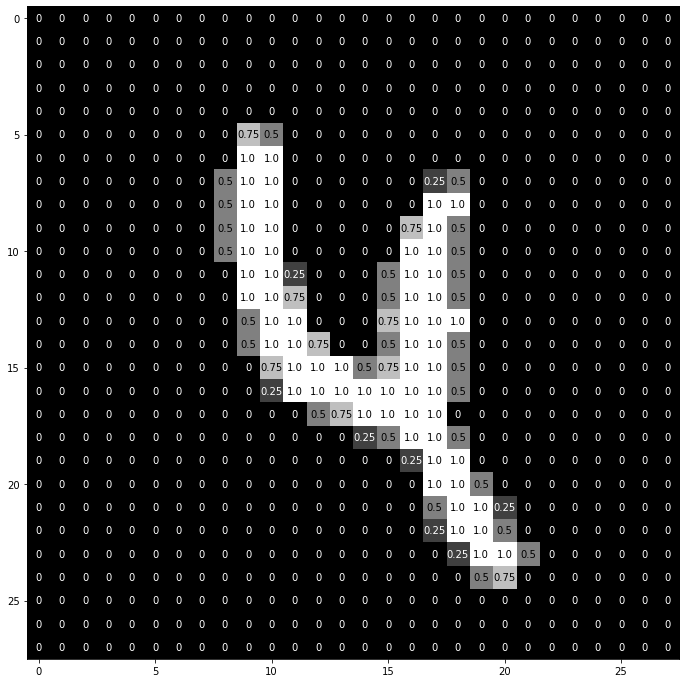

In [6]:
img = np.squeeze(images[1])
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [10]:
# define NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28*28, 512)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(512,512)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(512,10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.droput = nn.Dropout(0.2)
        
    def forward(self,x):
        # flatten image input
        x = x.view(-1,28*28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.droput(x)
         # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.droput(x)
        # add output layer
        x = self.fc3(x)
        return x
# initialize the NN
model = Net()
print(model)


Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (droput): Dropout(p=0.2, inplace=False)
)


In [11]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

In [ ]:
# number of epochs to train the model
n_epochs = 50
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf  # set initial "min" to infinity
for epoch in range(n_epochs):
    # monitor losses
    train_loss = 0
    valid_loss = 0
    
     
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data,label in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * data.size(0)
        
        
     ######################    
    # validate the model #
    ######################
    model.eval()  # prep model for evaluation
    for data,label in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # update running validation loss 
        valid_loss = loss.item() * data.size(0)
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.954807 	Validation Loss: 0.000468
Validation loss decreased (inf --> 0.000468).  Saving model ...
Epoch: 2 	Training Loss: 0.353907 	Validation Loss: 0.000937
Epoch: 3 	Training Loss: 0.284585 	Validation Loss: 0.000113
Validation loss decreased (0.000468 --> 0.000113).  Saving model ...
Epoch: 4 	Training Loss: 0.235019 	Validation Loss: 0.000600
Epoch: 5 	Training Loss: 0.201021 	Validation Loss: 0.000095
Validation loss decreased (0.000113 --> 0.000095).  Saving model ...
Epoch: 6 	Training Loss: 0.172419 	Validation Loss: 0.000030
Validation loss decreased (0.000095 --> 0.000030).  Saving model ...
Epoch: 7 	Training Loss: 0.152726 	Validation Loss: 0.000133
Epoch: 8 	Training Loss: 0.138582 	Validation Loss: 0.000129
Epoch: 9 	Training Loss: 0.124768 	Validation Loss: 0.000224
Epoch: 10 	Training Loss: 0.113248 	Validation Loss: 0.000490
Epoch: 11 	Training Loss: 0.103224 	Validation Loss: 0.000711
Epoch: 12 	Training Loss: 0.094746 	Validation Loss: 0.0